Ciclo Crisis 52-55 ignorado (fuera de rango)
Ciclo Expansión 56-69 ignorado (fuera de rango)
Ciclo Recesión 70-81 ignorado (fuera de rango)
Ciclo Crisis 82-84 ignorado (fuera de rango)


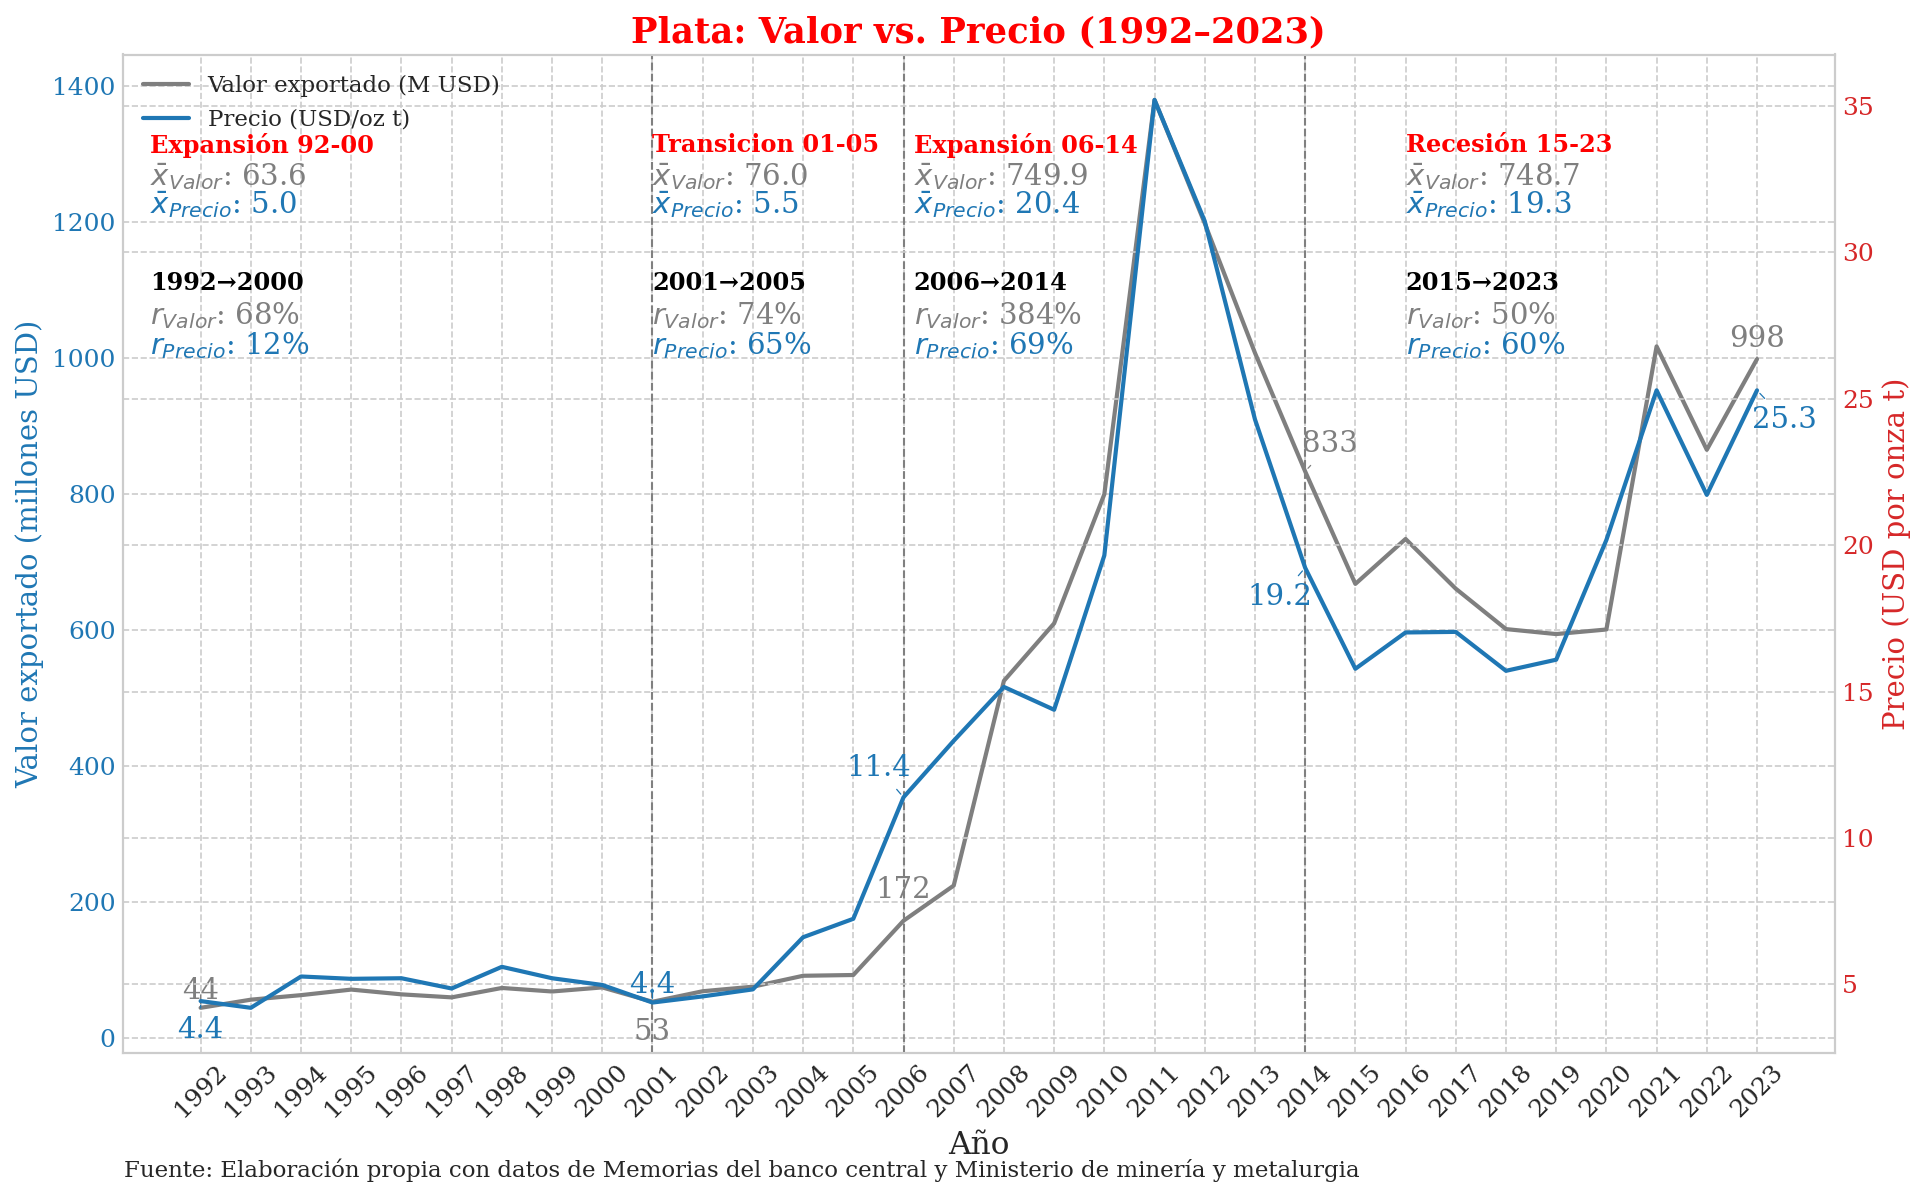

In [21]:
# ─────────────────────────────  PREPARACIÓN  ──────────────────────────────
import sys, os, sqlite3
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath('../'))
from graficos_utils import *
from func_auxiliares.config import *


output_dir = "../../../../assets/tesis/serie_completa/minerales"
os.makedirs(output_dir, exist_ok=True)

set_style()

# 1. Datos ────────────────────────────────────────────────────────────────
with sqlite3.connect("../../../../db/proyectomacro.db") as conn:
    df_plata = (pd.read_sql(
        "SELECT año, plata_volumen, plata_valor "
        "FROM exportaciones_minerales_totales WHERE año > 1991", conn)
        .set_index("año")
        .sort_index()
    )
    df_precio = (pd.read_sql(
        "SELECT año, plata AS precio_usd_ot "
        "FROM precio_oficial_minerales WHERE año > 1991", conn)
        .set_index("año")
        .sort_index()
    )

df = df_plata.join(df_precio, how="inner")
df["plata_valor_musd"] = df["plata_valor"] / 1_000   # miles → millones
df.drop(columns="plata_valor", inplace=True)

# ───────────────────────  GRÁFICA DUAL AXIS (valor-precio) ───────────────────────
cols   = ["plata_valor_musd", "precio_usd_ot"]
abbr   = {"plata_valor_musd": "Valor", "precio_usd_ot": "Precio"}
colors = {"plata_valor_musd": "#7f7f7f", "precio_usd_ot": "#1f77b4"}


CYCLES = adjust_cycles(df, CYCLES)
cycle_stats = {n: df.loc[s, cols].mean().to_dict() for n, s in CYCLES.items()}

hitos_offset = {yr: .60 for yr in hitos_v}

anot_years = adjust_annot_years(df, annot_years)
growth_periods = adjust_periods(df, periodos_tasas)
annotation_offsets = {
    "plata_valor_musd": {
        1992:(0,25), 2001:(0,-45), 2006:(0,45),
        2014:(0.5,40), 2023:(0,30)
    },
    "precio_usd_ot": {
        1992:(0,-1), 2001:(0,0.6), 2006:(-0.5,1),
        2014:(-0.5,-1), 2023:(0.55,-1)
    },
}

period_growth_offsets = {
    "1992-2000": (1991,0.78), "2001-2005":(2001,0.78),
    "2006-2014": (2006.2,0.78), "2015-2023":(2016,0.78)
}
cycle_text_offsets = {
    "Expansión 92-00": (1991,0.92),
    "Transicion 01-05":    (2001,0.92),
    "Expansión 06-14": (2006.2,0.92),
    "Recesión 15-23":  (2016,0.92),
}

# ────────────────────── GRÁFICA DUAL AXIS (valor–precio) ───────────────────────
left_series  = [("plata_valor_musd", "Valor exportado (M USD)")]
right_series = [("precio_usd_ot",      "Precio (USD/oz t)")]

fig, ax_val, ax_price = init_dual_axis_plot(
    df=df,
    left_series=left_series,
    right_series=right_series,
    colors=colors,
    title=f"Plata: Valor vs. Precio ({df.index[0]}–{df.index[-1]})",
    xlabel="Año",
    left_ylabel="Valor exportado (millones USD)",
    right_ylabel="Precio (USD por onza t)",
    source_text="Fuente: Elaboración propia con datos de Memorias del banco central y Ministerio de minería y metalurgia"
)

add_hitos(ax_val, df.index, hitos_v, hitos_offset, line_kwargs={"lw":1})
add_cycle_means_multi(
    ax_val, cycle_stats, cycle_text_offsets,
    abbr, colors, line_spacing=df["plata_valor_musd"].max()*0.03,
    value_fmt="{:,.1f}"
)
add_year_value_annotations(
    ax_val, df, anot_years, ["plata_valor_musd"],
    {"plata_valor_musd": annotation_offsets["plata_valor_musd"]},
    {"plata_valor_musd": colors["plata_valor_musd"]}, arrow_lw=0.6
)
add_year_value_annotations(
    ax_price, df, anot_years, ["precio_usd_ot"],
    {"precio_usd_ot": annotation_offsets["precio_usd_ot"]},
    {"precio_usd_ot": colors["precio_usd_ot"]}, arrow_lw=0.6,
    value_fmt="{:,.1f}"
)
add_period_growth_annotations_multi(
    ax_val, df, growth_periods, cols,
    period_growth_offsets, colors, abbr
)


h,l   = ax_val.get_legend_handles_labels()
h2,l2 = ax_price.get_legend_handles_labels()
hl    = [(x,y) for x,y in zip(h+h2, l+l2) if not y.startswith('_')]
if hl: ax_val.legend(*zip(*hl), loc="upper left", fontsize=11)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "plata_valor_precio_dual_axis.png"), dpi=300)
plt.show()


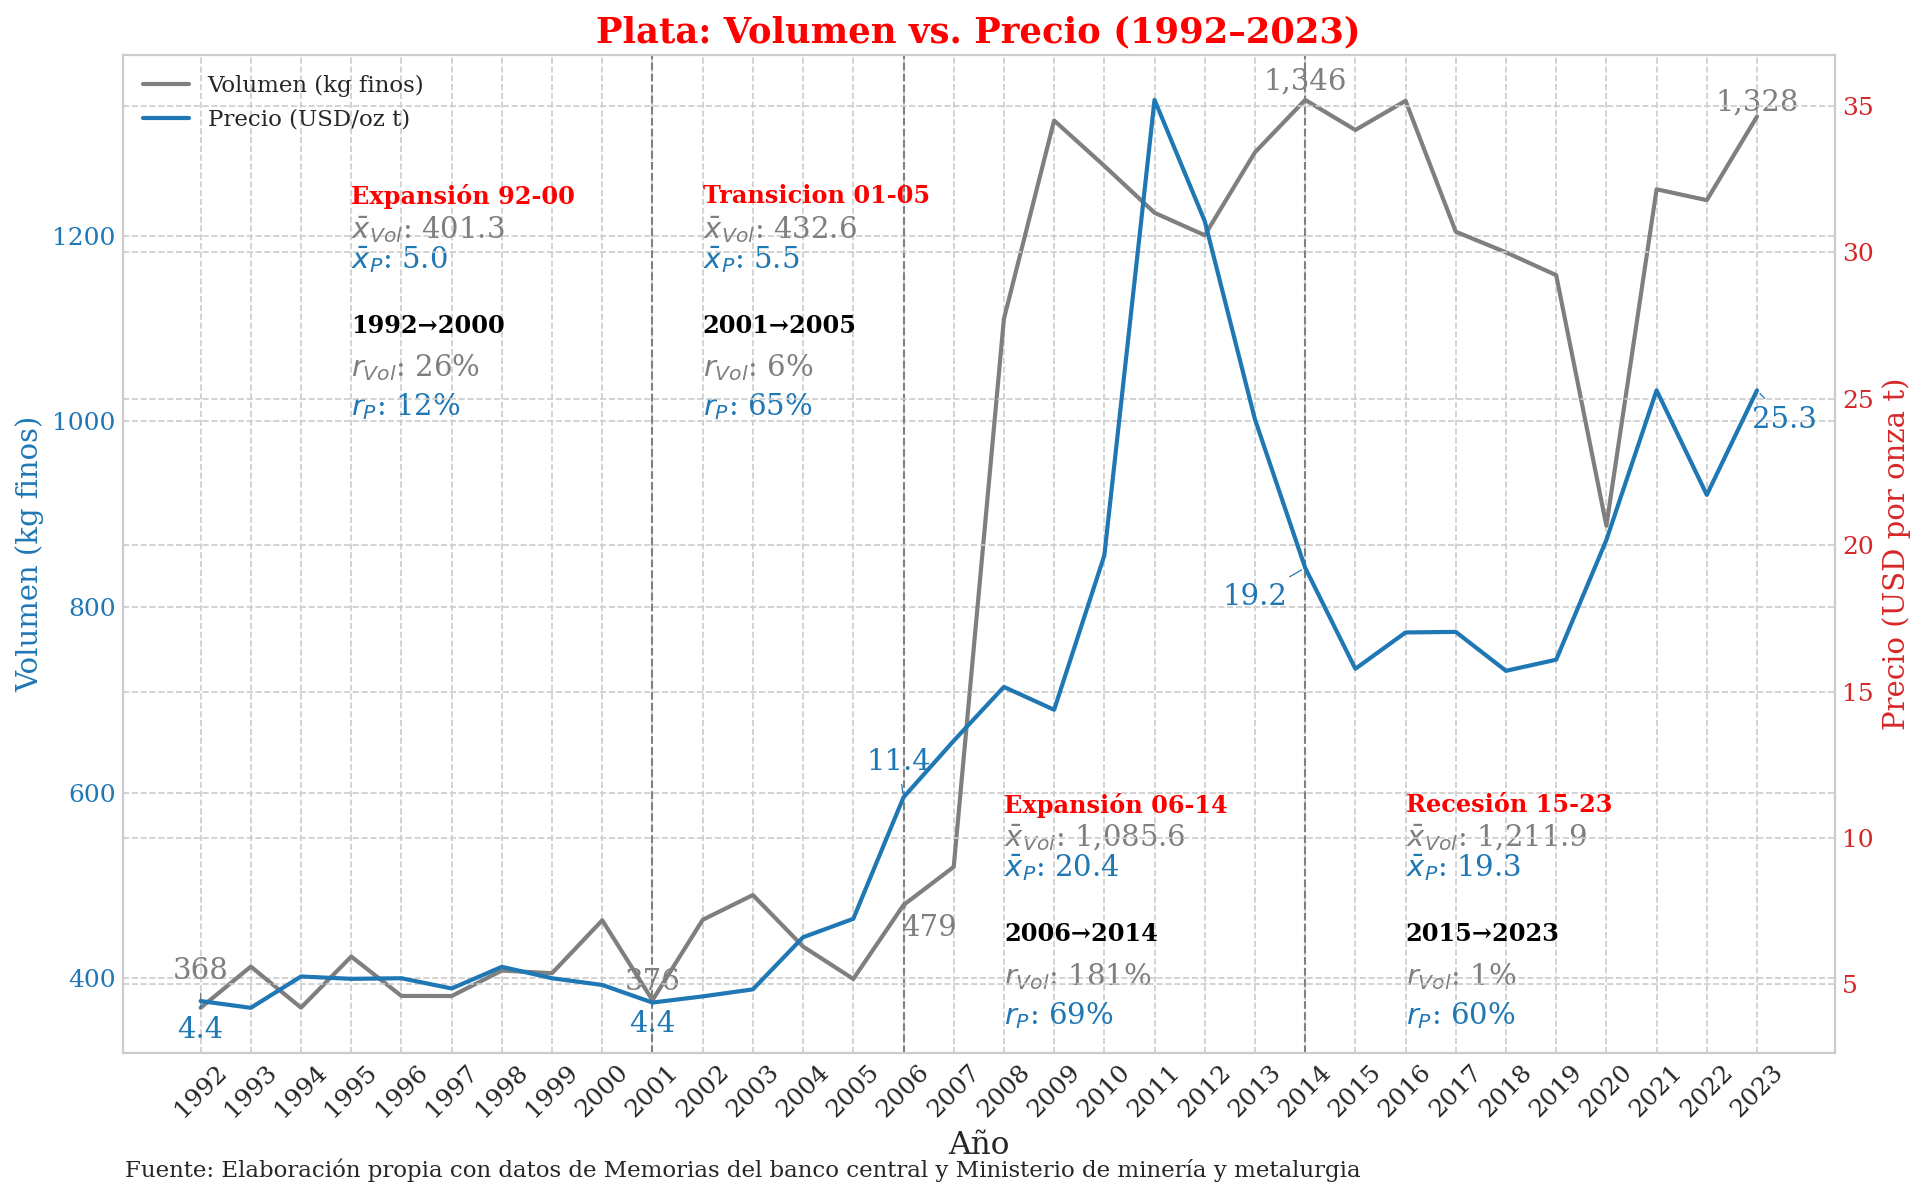

In [22]:
# ──────────────────  GRÁFICA DUAL AXIS (volumen-precio) ──────────────────
cols_vol   = ["plata_volumen", "precio_usd_ot"]
colors_vol = {
    "plata_volumen": "tab:gray",
    "precio_usd_ot": colors["precio_usd_ot"]          # azul del gráfico principal
}
abbr_vol = {"plata_volumen": "Vol", "precio_usd_ot": "P"}

cycle_stats_vol = {
    n: df.loc[s, cols_vol].mean().to_dict()
    for n, s in CYCLES.items()
}

annotation_offsets_vol = {
    "plata_volumen": {
        1992:(0,40), 2001:(0,20), 2006:(0.5,-25),
        2014:(0,20), 2023:(0,15)
    },
    "precio_usd_ot": {
        1992:(0,-1), 2001:(0,-0.73), 2006:(-0.1,1.2),
        2014:(-1,-1), 2023:(0.55,-1)
    }
}

period_growth_offsets_vol = {
    "1992-2000": (1995,0.80), "2001-2005":(2002,0.80),
    "2006-2014": (2008,0.33), "2015-2023":(2016,0.33)
}

cycle_text_offsets_vol = {
    "Expansión 92-00": (1995,0.90),
    "Transicion 01-05":    (2002,0.90),
    "Expansión 06-14": (2008,0.43),
    "Recesión 15-23":  (2016,0.43),
}

# ──────────────────────  GRÁFICA DUAL AXIS (volumen–precio) ─────────────────────
left_series_vol  = [("plata_volumen", "Volumen (kg finos)")]
right_series_vol = [("precio_usd_ot",  "Precio (USD/oz t)")]

fig_v, ax_v, ax_price_v = init_dual_axis_plot(
    df=df,
    left_series=left_series_vol,
    right_series=right_series_vol,
    colors=colors_vol,
    title=f"Plata: Volumen vs. Precio ({df.index[0]}–{df.index[-1]})",
    xlabel="Año",
    left_ylabel="Volumen (kg finos)",
    right_ylabel="Precio (USD por onza t)",
    source_text="Fuente: Elaboración propia con datos de Memorias del banco central y Ministerio de minería y metalurgia"
)

# hitos
add_hitos(ax_v, df.index, hitos_v, hitos_offset, line_kwargs={"lw":1})

# espaciado relativo
y_min, y_max = ax_v.get_ylim()
line_spacing = (y_max - y_min) * 0.03

# medias por ciclo
add_cycle_means_multi(
    ax_v, cycle_stats_vol, cycle_text_offsets_vol,
    abbr_vol, colors_vol, line_spacing=line_spacing,
    value_fmt="{:,.1f}"
)

# anotaciones de año
add_year_value_annotations(
    ax_v, df, anot_years, ["plata_volumen"],
    {"plata_volumen": annotation_offsets_vol["plata_volumen"]},
    {"plata_volumen": colors_vol["plata_volumen"]}, arrow_lw=0.6
)
add_year_value_annotations(
    ax_price_v, df, anot_years, ["precio_usd_ot"],
    {"precio_usd_ot": annotation_offsets_vol["precio_usd_ot"]},
    {"precio_usd_ot": colors_vol["precio_usd_ot"]}, arrow_lw=0.6,
    value_fmt="{:,.1f}"
)

# tasas de crecimiento
add_period_growth_annotations_multi(
    ax_v, df, growth_periods, cols_vol,
    period_growth_offsets_vol, colors_vol, abbr_vol,
    line_spacing_ratio=0.03
)


h1,l1 = ax_v.get_legend_handles_labels()
h2,l2 = ax_price_v.get_legend_handles_labels()
ax_v.legend(h1+h2, l1+l2, loc="upper left", fontsize=11)

plt.tight_layout()
plt.savefig(os.path.join(output_dir,"plata_volumen_precio_dual_axis.png"), dpi=300)
plt.show()

